<center><h2>Tweets Sentiment analysis</h2></center>

github : https://github.com/AyoubLaar/SPARK-STREAMING-PFA/tree/main/Model

<p>For real time tweets sentiment analysis, we need to train a model to help us predict whether tweets are in support of palestine or israel.</p>
<p>Our model will only be able to predict tweets as either supporting of israel or palestine, the model is unable to detect neutral tweets.</p>
<p>We scrapped the data from twitter using selenium.</p>

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, TextVectorization ,Embedding ,GlobalAveragePooling1D ,Dropout ,SpatialDropout1D, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
import re

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

pd.options.display.max_colwidth = 300
pass

In [13]:
data = pd.read_csv("data/data.csv",on_bad_lines='skip')
data.head()

,post,usertag,time_date,label,__key__,__error__,__has_error__
0,NaN,NaN,NaN,NaN,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""startingdoc\"""",\n ""kind"": ""posts"",\n ""name"": ""startingdoc"",\n ""id"": null\n }\n}",[],False
1,https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...,@Big0range31,2023-12-30 22:55:29,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5SltHdL2FYtDuVweFRXg\"""",\n ""kind"": ""posts"",\n ""name"": ""5SltHdL2FYtDuVweFRXg"",\n ""id"": null\n }\n}",[],False
2,#IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News,@LorraineMayLevy,2024-01-29 13:45:32,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EGsMYmUyHTQeVd27d2c\"""",\n ""kind"": ""posts"",\n ""name"": ""5EGsMYmUyHTQeVd27d2c"",\n ""id"": null\n }\n}",[],False
3,"#istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.",@SapphosShahuda,2023-11-29 00:21:06,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EdJPNUV8Mw4xprgaOCu\"""",\n ""kind"": ""posts"",\n ""name"": ""5EdJPNUV8Mw4xprgaOCu"",\n ""id"": null\n }\n}",[],False
4,"The images of Hamas' brutality are gruesome — reminiscent of the worst of Al-Qaeda, ISIS and the Taliban.\n\nUrge America's leaders to #StandWithIsrael as it defeats this terrorist threat:",@Deborah83556516,2024-01-26 02:35:05,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5H9s7aG3b8v8wunxXV3B\"""",\n ""kind"": ""posts"",\n ""name"": ""5H9s7aG3b8v8wunxXV3B"",\n ""id"": null\n }\n}",[],False


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13163 entries, 0 to 13162
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   post           13162 non-null  object
 1   usertag        13162 non-null  object
 2   time_date      13162 non-null  object
 3   label          13162 non-null  object
 4   __key__        13163 non-null  object
 5   __error__      13163 non-null  object
 6   __has_error__  13163 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 630.0+ KB


<p>the first row is the only row with missing values, let's remove it.</p>

In [15]:
data = data.tail(len(data) - 1)

In [16]:
data.columns = ["text","usertag","date","label","__key__","__err __","__has_err __"]
data = data.astype(str)
data["target"] = data["label"].apply(lambda x: 0 if x == "P" else 1)

<p>No error  in the dataset exporting the file from firebase.</p>

In [6]:
data["__has_err __"].unique()

array(['False'], dtype=object)

<p>we will drop key , err and has__err columns.  </p>

In [17]:
data.drop(["__key__","__err __","__has_err __"],axis=1,inplace=True)

In [20]:
data = data.drop_duplicates()

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11951 entries, 1 to 13162
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     11951 non-null  object
 1   usertag  11951 non-null  object
 2   date     11951 non-null  object
 3   label    11951 non-null  object
 4   target   11951 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 560.2+ KB


<center><h2>Text processing</h2></center>

<p>For data labeling, we labeled tweets containing pro palestinian tags as in support of palestine (P)  and tweets containing pro israeli tags we labeled them as in support of israel (I).</p>
<p>Here are the tags used :</p>
<ul>
<li>
Pro Palestine tags : #freepalestine
#supportpalestine
#standwithpalestine
#istandwithpalestine
#westandwithpalestine</li>
<li>
Pro Israel tags :  #freeisrael
#supportisrael
#standwithisrael
#istandwithisrael
#westandwithisrael</li>
</ul>
<p>Out of fear that these tags will bias the model too much, we will create a clone of the original dataset, remove the tags, then append it to the original dataset. This way the model will be able to recognize the tags but also not be overly dependent on them.</p>

In [22]:
search_tags = ["#freepalestine","#supportpalestine","#standwithpalestine","#istandwithpalestine","#westandwithpalestine",
               "#freeisrael","#supportisrael","#standwithisrael","#istandwithisrael","#westandwithisrael"]
data2 = data.copy()
data2["text"] = data["text"].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in search_tags))

In [23]:
data["text"].head(5)

1    https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...
2                                                                                                                                                                                                                #IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News
3                                                                                         #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                                    

word cloud for data with search tags, as feared the tags appear as the most frequent words, there isn't much variety.

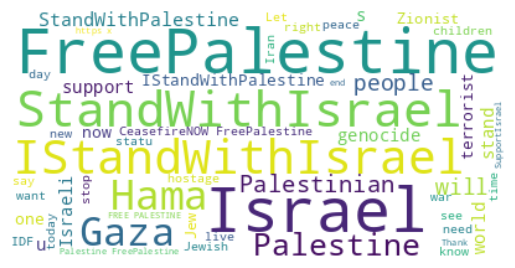

In [24]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

word cloud for data without search tags, we notice a lot more variety in the words.



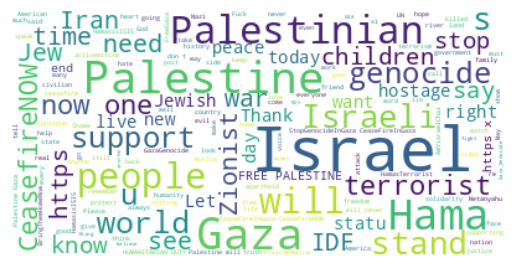

In [25]:
text = " ".join(review for  review in data2["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I will merge the two datasets into one

In [26]:
data = pd.concat([data,data2])

here is the new word cloud , hopefully this will stop the model from relying too much on the labeling tags so it can be more reliable for predicting tweets that do not contain them.

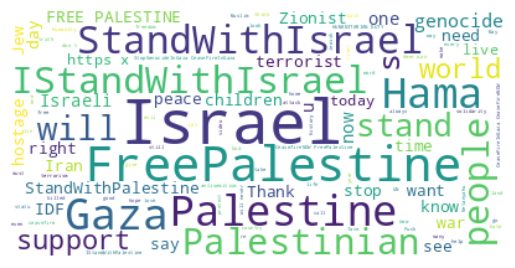

In [27]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Removing URLs, Mentions, Emojis

In [15]:
import preprocessor  as p
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.EMOJI,p.OPT.SMILEY,p.OPT.NUMBER)
data["text"] = data["text"].apply(lambda x : p.clean(x))

In [16]:
data["text"]

1                                    The Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrael #SupportIsrael
2                                                                                                                                                          #IStandWithIsrael thousands at event calling for the country's resettlement of Gaza - NBC News
3                                      #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. Stand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                 The images of Hamas' brutality are gruesome reminiscent of the worst of Al-Qaeda, ISIS and the Taliban. Urge America's leaders to #StandWithIsrael as it defeats this terrorist threat:


#### Removing punctuation

In [17]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
data['text'] = data['text'].apply(lambda x: re.sub(f'[{re.escape(punctuation)}]', '' , str(x)))

#### Camel Case
<p>I noticed a norme of words being combined in a camel case format, where each word starts with a capital letter (EX: #PalestineWillBeFree), we will attempt to seperate these words.</p>

In [19]:
def split_camel_case(word):
    # Regular expression to match camel case patterns, including acronyms
    split_words = re.sub('([a-z0-9])([A-Z])', r'\1 \2', word)
    split_words = re.sub('([A-Z])([A-Z][a-z])', r'\1 \2', split_words)
    return " ".join(split_words.split())

data["text"] = data["text"].apply(split_camel_case)

#### Expanding contractions

In [20]:
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
data['text']=data['text'].apply(lambda x:expand_contractions(str(x)))

#### Lower case

In [21]:
data["text"] = data["text"].str.lower()

#### Stop words

In [22]:
from wordcloud import STOPWORDS
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in STOPWORDS]))

#### Lemmatization and stemming

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import nltk
from nltk.stem import PorterStemmer
 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return "n"

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def lemmatize_stem_words(text):
    tokens = text.split(" ")
    tagged_tokens = nltk.pos_tag(tokens)
    return " ".join([ps.stem(lemmatizer.lemmatize(word,penn_to_wn(pos))) for word,pos in tagged_tokens])
data["text"] = data["text"].apply(lambda text: lemmatize_stem_words(text))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ayoub/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ayoub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
data["text"]

1        depart justic job protect nazi democrat keep treason crime cover nazi scum resist democrat fascism democrat new nazi stand israel support israel
2                                                                                          stand israel thousand event call countri resettl gaza nbc news
3                            istandwithisrael istandwithjew mean stand israel militaris ethno state stand jewish peopl barbarian respons idf state israel
4                                      imag hama brutal gruesom reminisc bad al qaeda isi taliban urg america leader stand israel defeat terrorist threat
5                                                                                    well worth read excel histor perspect bring present day stand israel
                                                                               ...                                                                       
13158                                                                       

<p>All preprocessing in one function</p>

In [30]:
from preprocess import preprocess

data["text"] = data["text"].apply(preprocess)

#### handling data imbalance

<p>There is a bias in the data, we need to make sure there are as many posts in support of palestine as there are in support of israel.</p>

<Axes: xlabel='label', ylabel='count'>

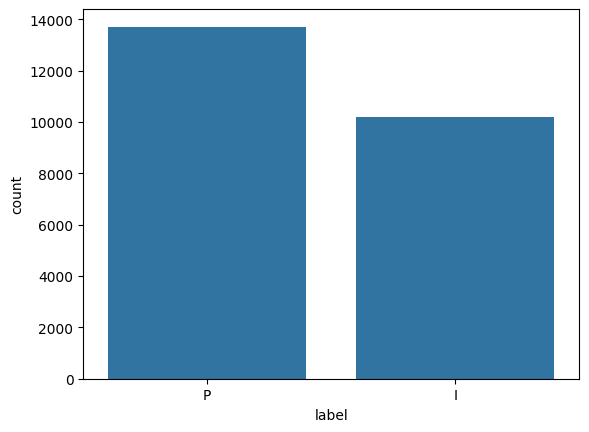

In [34]:
sns.barplot(data["label"].value_counts())

<Axes: xlabel='label', ylabel='count'>

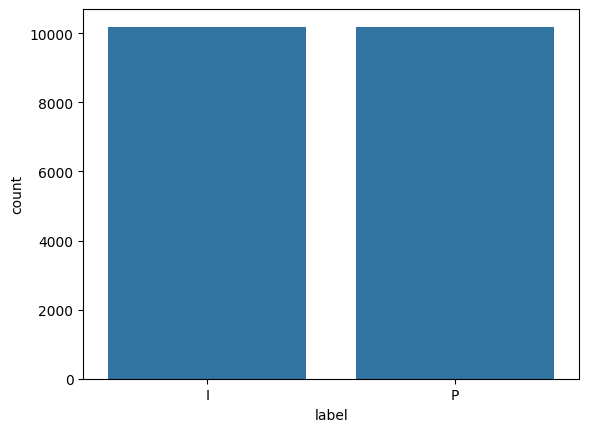

In [33]:
g = data.groupby("label")
data_balanced = g.head(min(data["label"].value_counts()))
sns.barplot(data_balanced["label"].value_counts())

In [35]:
data = data_balanced

#### Final Dataset

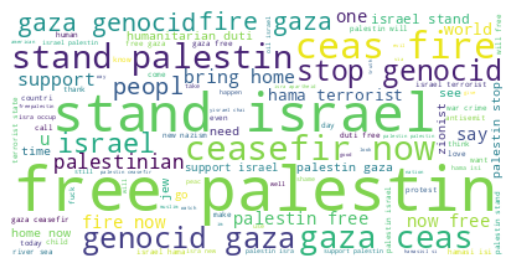

In [27]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

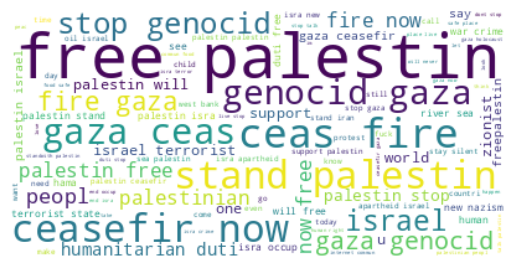

In [28]:
text = " ".join(review for review in data.loc[data["label"] == "P"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

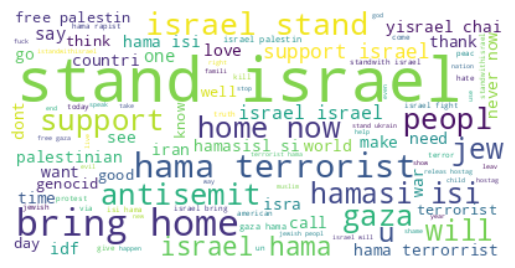

In [29]:
text = " ".join(review for review in data.loc[data["label"] == "I"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
data["text"]

1        depart justic job protect nazi democrat keep treason crime cover nazi scum resist democrat fascism democrat new nazi stand israel support israel
2                                                                                          stand israel thousand event call countri resettl gaza nbc news
3                            istandwithisrael istandwithjew mean stand israel militaris ethno state stand jewish peopl barbarian respons idf state israel
4                                      imag hama brutal gruesom reminisc bad al qaeda isi taliban urg america leader stand israel defeat terrorist threat
5                                                                                    well worth read excel histor perspect bring present day stand israel
                                                                               ...                                                                       
13158                                                                       

<center><h2>Model training</h2></center>

#### Train test Split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data["text"],data["target"], test_size=0.2,random_state=42)
x_train = pd.Series.to_numpy(x_train)
x_test = pd.Series.to_numpy(x_test)
y_train = pd.Series.to_numpy(y_train)
y_test = pd.Series.to_numpy(y_test)

#### Tokenization

In [38]:
MAX_SEQUENCE_LENGTH = 280
VOCAB_SIZE = 10000
int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [39]:
int_vectorize_layer.adapt(x_train)

#### Dense Model

In [34]:
vocab_size = 10000
embedding_dim = 16
drop_value = 0.2
n_dense = 24
MAX_SEQUENCE_LENGTH = 280
model = Sequential()
model.add(int_vectorize_layer)
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = MAX_SEQUENCE_LENGTH))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
num_epochs = 15
history = model.fit(x_train,
                     y_train,
                     epochs=num_epochs,
                     verbose=2)

Epoch 1/15
549/549 - 2s - 4ms/step - accuracy: 0.5758 - loss: 0.6754
Epoch 2/15
549/549 - 1s - 2ms/step - accuracy: 0.8064 - loss: 0.4526
Epoch 3/15
549/549 - 1s - 2ms/step - accuracy: 0.8751 - loss: 0.3042
Epoch 4/15
549/549 - 1s - 2ms/step - accuracy: 0.8820 - loss: 0.2795
Epoch 5/15
549/549 - 1s - 2ms/step - accuracy: 0.8907 - loss: 0.2687
Epoch 6/15
549/549 - 1s - 2ms/step - accuracy: 0.8931 - loss: 0.2575
Epoch 7/15
549/549 - 1s - 2ms/step - accuracy: 0.8981 - loss: 0.2489
Epoch 8/15
549/549 - 1s - 2ms/step - accuracy: 0.9031 - loss: 0.2378
Epoch 9/15
549/549 - 1s - 2ms/step - accuracy: 0.9034 - loss: 0.2378
Epoch 10/15
549/549 - 1s - 2ms/step - accuracy: 0.9047 - loss: 0.2321
Epoch 11/15
549/549 - 1s - 2ms/step - accuracy: 0.9043 - loss: 0.2366
Epoch 12/15
549/549 - 1s - 2ms/step - accuracy: 0.9024 - loss: 0.2402
Epoch 13/15
549/549 - 1s - 2ms/step - accuracy: 0.9116 - loss: 0.2248
Epoch 14/15
549/549 - 1s - 2ms/step - accuracy: 0.9106 - loss: 0.2259
Epoch 15/15
549/549 - 1s - 2m

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 280)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 280, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,301 (98.84 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,868 (65.89 KB)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9138 - loss: 0.2136
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


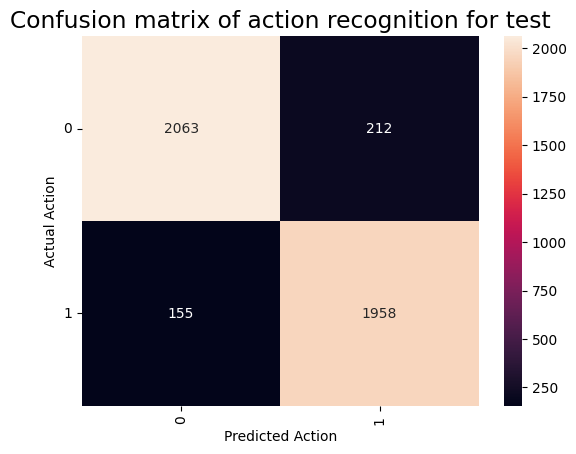

In [37]:
model.evaluate(x_test,y_test)
binary_predictions = (model.predict(x_test) >= 0.5).astype(int)
plot_confusion_matrix(binary_predictions,y_test,[0,1],"test")

In [38]:
print(classification_report(binary_predictions, y_test))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2275
           1       0.90      0.93      0.91      2113

    accuracy                           0.92      4388
   macro avg       0.92      0.92      0.92      4388
weighted avg       0.92      0.92      0.92      4388



<p>we test the model with our own input data and it fails to recognize the last two elements reliably.</p>

In [39]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
(model.predict(text) >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ayoub/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ayoub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


array([[1],
       [0],
       [1],
       [0]])

#### LSTM

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense, Input, Concatenate
from tensorflow.keras.models import Model

vocab_size = 10000
embedding_dim = 16
drop_value = 0.2
n_dense = 24
n_lstm = 128
drop_lstm = 0.2
MAX_SEQUENCE_LENGTH = 280

input_layer = Input(shape=(1,),dtype=tf.string)
x = int_vectorize_layer(input_layer)
x = Embedding(vocab_size, embedding_dim)(x)
x = SpatialDropout1D(drop_lstm)(x)

#Changed Bidirectionnal to this
forward_lstm = LSTM(units=32, return_sequences=False, name='forward_lstm')(x)
backward_lstm = LSTM(units=32, return_sequences=False, go_backwards=True, name='backward_lstm')(x)
concat_lstm = Concatenate()([forward_lstm, backward_lstm])

x = Dropout(drop_lstm)(concat_lstm)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)
model1 = Model(inputs=input_layer, outputs=output_layer)
model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model1.summary()
#For me this line of code didn't work until i downloaded graphviz
#sudo apt-get install graphviz 
tf.keras.utils.plot_model(model1, show_shapes=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 280)       │          0 │ input_layer_2[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 280, 16)   │    160,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 280, 16)   │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forward_lstm (LSTM) │ (None, 32)        │      6,272 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backward_lstm       │ (None, 32)        │      6,272 │ spatial_dropout1… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ forward_lstm[0][… │
│ (Concatenate)       │                   │            │ backward_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,233 (747.00 KB)

 Trainable params: 191,233 (747.00 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<p>LSTM reaches higher accuracy faster than the dense model.</p>

In [42]:
num_epochs = 5
history = model1.fit(x_train,
                     y_train,
                     epochs=num_epochs,
                     verbose=2)

Epoch 1/5
510/510 - 57s - 111ms/step - accuracy: 0.8737 - loss: 0.2814
Epoch 2/5
510/510 - 52s - 103ms/step - accuracy: 0.9492 - loss: 0.1367
Epoch 3/5
510/510 - 53s - 103ms/step - accuracy: 0.9655 - loss: 0.0958
Epoch 4/5
510/510 - 53s - 104ms/step - accuracy: 0.9738 - loss: 0.0744
Epoch 5/5
510/510 - 53s - 104ms/step - accuracy: 0.9789 - loss: 0.0615


In [43]:
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 280)       │          0 │ input_layer_2[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 280, 16)   │    160,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 280, 16)   │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forward_lstm (LSTM) │ (None, 32)        │      6,272 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backward_lstm       │ (None, 32)        │      6,272 │ spatial_dropout1… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ forward_lstm[0][… │
│ (Concatenate)       │                   │            │ backward_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 573,701 (2.19 MB)

 Trainable params: 191,233 (747.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 382,468 (1.46 MB)

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


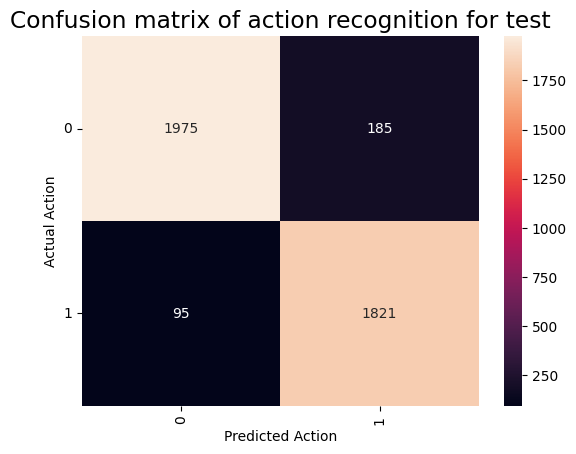

In [44]:
binary_predictions = (model1.predict(x_test) >= 0.5).astype(int)
plot_confusion_matrix(binary_predictions,y_test,[0,1],"test")

In [45]:
print(classification_report(binary_predictions, y_test))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2160
           1       0.91      0.95      0.93      1916

    accuracy                           0.93      4076
   macro avg       0.93      0.93      0.93      4076
weighted avg       0.93      0.93      0.93      4076



LSTM also fails this test.

In [46]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
(model1.predict(text) >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[1],
       [0],
       [1],
       [0]])

#### Saving LSTM model in a file
<p>This is the model we will use for the spark streaming application.</p>

In [48]:
from tensorflow.keras import layers
import json

model1.save("model/model.keras")

<p>let's test loading and using the model</p>

In [49]:
from keras.models import load_model

model_file = "model/model.keras"

def build_model():
    model = load_model(model_file)
    return model

loaded_model = build_model()
# loaded_model = build_model()
# loaded_model.load_weights("model/model.weights.h5")

is keras


In [50]:
loaded_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 280)       │          0 │ input_layer_2[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 280, 16)   │    160,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 280, 16)   │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forward_lstm (LSTM) │ (None, 32)        │      6,272 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backward_lstm       │ (None, 32)        │      6,272 │ spatial_dropout1… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ forward_lstm[0][… │
│ (Concatenate)       │                   │            │ backward_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 573,701 (2.19 MB)

 Trainable params: 191,233 (747.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 382,468 (1.46 MB)

<p>The model gives the same results.</p>

In [51]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
loaded_model.predict(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


array([[0.90005034],
       [0.01018229],
       [0.85553217],
       [0.00883098]], dtype=float32)

#### Final test
<p>Since we used tags to label the data automatically, we need to check the reliability of this labeling method. Which is why we will test the model on data that we labelled manually</p>

In [20]:
# unlabeled_data = pd.read_csv("data/unlabeled_tweets.csv")
# unlabeled_data.columns = ["text","usertag","date","label","__key__","__err __","__has_err __"]
# unlabeled_data = unlabeled_data.astype(str)
# unlabeled_data.drop(["__key__","__err __","__has_err __"],axis=1,inplace=True)
# unlabeled_data.drop_duplicates(inplace=True)
# unlabeled_data.sample(100).to_csv("test_data.csv",index=False)

<p>I sampled 100 random rows of the unlabeled.csv dataset, then I labeled them as either in support of palestine or israel, if they were neutral i deleted them from the data, which is why there are less than 100 rows.</p>

In [52]:
final_test = pd.read_csv("data/test_data.csv")

In [53]:
final_test

,text,usertag,date,label
0,Stupidass #Israel \n#WarCriminal #IsraelPalestineWAR \n#military #leadership \n@UN\n's top court orders Israel to stop its assault on #Rafah https://youtu.be/EHtnOQPneI4 #YouTube #news #video,@sdlizlifestyle,2024-05-25 05:06:05,P
1,"The crying and whining that Israelis, Jews and their bootlickers are doing over the ICJ is hilarious! Just like a toddler throwing a tantrum after being told to stop doing something. Actually no, their behaviours much worse and childish\n#Palestine #EndTheGenocide",@sbari0105,2024-05-25 09:15:16,P
2,AsslamuAlikum guyz..\n\n#Origin #Euro2024 #FridayMotivation #Euro2024 #MetGala2024 #matura2024 #Eurovision2024 #Rafah #GoodMorningTwitterWorld #PerfectMatchExtra #Palestine #บางกอกคณิกาep1 #twstプラス,@abubakar787624,2024-05-18 02:27:31,P
3,"Original #artwork, ""Untitled 2"" for #investing. Absolutely one of a kind #painting. Free all #children. #Ukraine #Palestine #Gaza #Russia #Israel #war #peace #rebel #popart #surreal #rock #contemporary https://ebay.com/itm/335402484450?mkcid=16&mkevt=1&mkrid=711-127632-2357-0&ssspo=wNhNBFkHRbW...",@RTFCLLY_FLVRD,2024-05-25 09:00:23,P
4,"A #Palestinian shop named ""#Hitler"" – promoting peace and love? \n\nThis is why humanity can't accept a state where Hitler is a hero. \n\nIt's beyond #Gaza and #Israel; it's a battle of hate and #racism versus love and coexistence. \n\n#NoCeasefire",@Schulla007,2024-05-25 10:58:09,I
...,...,...,...,...
67,#Palestine Support & Humanitarian Aid #Space,@UniSocialNet,2024-05-18 02:16:39,P
68,"Sources: Al Jazeera English, History in color, Stef Hoffer (yt), Filastiniyat (X.). \n\n#Palestine #Gaza #Rafah #israel #FreePalestine #AllEyesOnRafah",@Thatt1era,2024-05-18 01:20:16,P
69,Foolish is the politic that sends munitions to any who disrespect INNOCENTS AND THEIR VOLUNTEER AIDERS.\nFast Phil shared a photo with you from the Flickr app. Check it out:\nhttps://flic.kr/p/2pGsBux #GazaGenocide‌ #palestine #SaveGazaCampaign,@NotAHorsesAss,2024-05-18 04:53:55,P
70,If #Netanyahu wants a #holywar #israel will be eradicated in hours \nDelusional world leader wow ##Putin HELP #Palestine and become new world leaders . #resume,@elonsatoshimusk,2024-05-18 04:17:08,P


<p>let's define the target variable and preprocess the text.</p>

In [54]:
from preprocess import preprocess

final_test["target"] = final_test["label"].apply(lambda x: 0 if x == "P" else 1)
final_test["text"] = final_test["text"].apply(preprocess)

In [55]:
final_test[["text","target"]]

,text,target
0,stupidass israel war crimin israel palestin war militari leadership s top court order israel stop assault rafah tube news video,0
1,cri whine isra jew bootlick icj hilari toddler throw tantrum tell stop someth actual behaviour much bad childish palestin end genocid,0
2,asslamu alikum guyz origin euro2024 friday motiv euro2024 meet gala2024 matura2024 eurovision2024 rafah good morn twitter world perfect match extra palestin ep1 twst,0
3,origin artwork untitl invest absolut one kind paint free child ukrain palestin gaza russia israel war peac rebel popart surreal rock contemporari e bay via,0
4,palestinian shop name hitler promot peac love human cant accept state hitler hero beyond gaza israel battl hate racism versu love coexist ceasefir,1
...,...,...
67,palestin support humanitarian aid space,0
68,sourc al jazeera english histori color stef hoffer yt filastiniyat x palestin gaza rafah israel free palestin eye rafah,0
69,foolish polit send munit disrespect innoc volunt aider fast phil share photo flickr app check gaza genocid palestin save gaza campaign,0
70,netanyahu want holywar israel will erad hour delusion world leader wow putin help palestin becom new world leader resum,0


In [56]:
type(final_test["text"])

pandas.core.series.Series

In [57]:
from keras.models import load_model

model = load_model("model/model.keras")
model.evaluate(final_test["text"],final_test["target"])
# plot_confusion_matrix(final_test["target"],binary_predictions,labels=[0,1],ds_type="final_test")

is keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9006 - loss: 0.5800


[0.5942204594612122, 0.9027777910232544]